<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/testing_models_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import time
import cv2
import numpy as np
import h5py
import random
from matplotlib import pyplot as plt
import os
import torch

torch.cuda.get_device_name(0)
#!nvidia-smi
! python --version

Python 3.7.15


In [2]:
# Preprocessing Inmuno21 dataset

path = 'drive/MyDrive/Colab_Notebooks/Tesis/Inmuno21_ds'
names = []
labels = []

with h5py.File('drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Inmuno21_dataset.h5', 'w', libver='latest') as f:
    for image_name in os.listdir(path):
        names.append(image_name)
        labels.append('_'.join(image_name.split('_')[:-1]))
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        green_channel = image[:,:,1]                                        # Extraemos el canal verde de de cada imagen
        image = np.zeros(image.shape)                                       # Imagen vacia
        image[:,:,1] = green_channel                                        # Sustituimos el canal verde en la imagen vacia, [2]
        image = (image - np.min(image))/(np.max(image) - np.min(image))     # Preprocesamiento para evitar ruido y normalizar cada canal, [2] y [8]
        image = cv2.resize(image, (224, 224)) 
        Inmuno21_dataset = f.create_dataset(image_name, data=image, compression='gzip')

print(len(labels))
print(len(names))

445
445


In [3]:
# # Preprocessing Inmuno21 dataset (clean up AC0, AC18 and AC25)
path = 'drive/MyDrive/Colab_Notebooks/Tesis/Inmuno21_ds'

names_clean = []    # Sin AC0, AC18 y AC25
labels_clean = []   # Sin AC0, AC18 y AC25

with h5py.File('drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Inmuno21_dataset_clean.h5', 'w', libver='latest') as f:
    for image_name in os.listdir(path):
        first_label = image_name.split('_')[:-1][0]
        if(first_label  == "AC0" or first_label  == "AC18" or first_label  == "AC25"):
            continue
        names_clean.append(image_name)
        labels_clean.append('_'.join(image_name.split('_')[:-1]))
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        green_channel = image[:,:,1]                                        # Extraemos el canal verde de de cada imagen
        image = np.zeros(image.shape)                                       # Imagen vacia
        image[:,:,1] = green_channel                                        # Sustituimos el canal verde en la imagen vacia, [2]
        image = (image - np.min(image))/(np.max(image) - np.min(image))     # Preprocesamiento para evitar ruido y normalizar cada canal, [2] y [8]
        image = cv2.resize(image, (224, 224)) 
        Inmuno21_dataset_clean = f.create_dataset(image_name, data=image, compression='gzip')

print(len(labels_clean))
print(len(names_clean))

388
388


Nombre de la imagen:  AC0_22.jpg
Etiqueta(s) de la imagen:  AC0


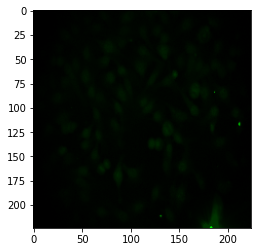

Nombre de la imagen:  AC0_5.jpg
Etiqueta(s) de la imagen:  AC0


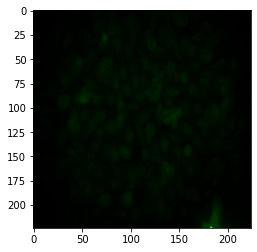

Nombre de la imagen:  AC5_28.jpg
Etiqueta(s) de la imagen:  AC5


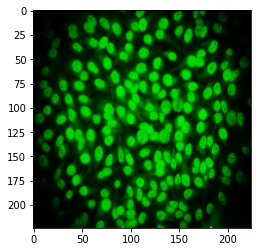

Nombre de la imagen:  AC5_27.jpg
Etiqueta(s) de la imagen:  AC5


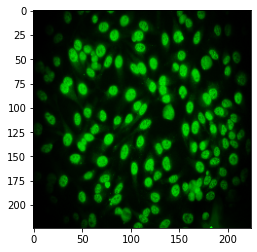

Nombre de la imagen:  AC5_26.jpg
Etiqueta(s) de la imagen:  AC5


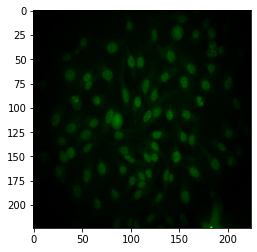

Nombre de la imagen (clean):  AC5_28.jpg
Etiqueta(s) de la imagen (clean):  AC5


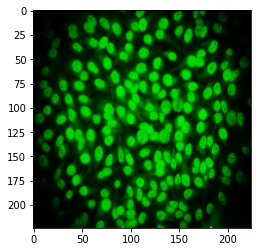

Nombre de la imagen (clean):  AC5_27.jpg
Etiqueta(s) de la imagen (clean):  AC5


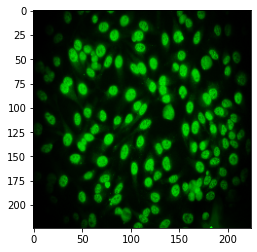

Nombre de la imagen (clean):  AC5_26.jpg
Etiqueta(s) de la imagen (clean):  AC5


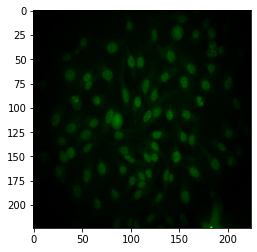

Nombre de la imagen (clean):  AC3_17.jpg
Etiqueta(s) de la imagen (clean):  AC3


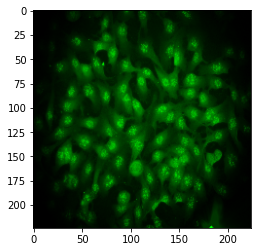

Nombre de la imagen (clean):  AC3_16.jpg
Etiqueta(s) de la imagen (clean):  AC3


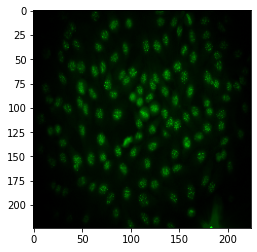

In [4]:
Inmuno21_dataset = h5py.File("drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Inmuno21_dataset.h5", 'r')
for i in range(0,5):
    image_name = names[i]
    image_label = labels[i]
    image = Inmuno21_dataset.get(image_name)[:]
    print("Nombre de la imagen: ", image_name)
    print("Etiqueta(s) de la imagen: ", image_label)
    plt.imshow(image)
    plt.show()


Inmuno21_dataset.close()

Inmuno21_dataset_clean = h5py.File("drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Inmuno21_dataset_clean.h5", 'r')
for i in range(0,5):
    image_name = names_clean[i]
    image_label = labels_clean[i]
    image = Inmuno21_dataset_clean.get(image_name)[:]
    print("Nombre de la imagen (clean): ", image_name)
    print("Etiqueta(s) de la imagen (clean): ", image_label)
    plt.imshow(image)
    plt.show()


Inmuno21_dataset_clean.close()

In [5]:
# Labeling 

def Binary_labeling(label_list):
  binary_labels = []
  for label in label_list:
    _class = [0, 0]
    if label == 'AC0':
      _class[0], _class[1] = 1, 0
    else: 
      _class[0], _class[1] = 0, 1
    binary_labels.append(_class)

  return binary_labels

def Basic_level_labeling(label_list):

  split_labels = []
  basic_level_labels_raw = []
  basic_level_labels = []
  basic_level_labels_to_model = []

  for label in label_list: # Separamos las etiquetas para cada muestra
    split_labels.append(label.split("_"))

  for label in split_labels:
    group = []
    for basic_label in label:
      if (basic_label == "AC1" or basic_label == "AC2" or basic_label == "AC3" or 
          basic_label == "AC4" or basic_label == "AC5" or basic_label == "AC6" or
          basic_label == "AC7" or basic_label == "AC8" or basic_label == "AC9" or
          basic_label == "AC10" or basic_label == "AC11" or basic_label == "AC12" or
          basic_label == "AC13" or basic_label == "AC29"): 
        group.append(0)
      elif (basic_label == "AC15" or basic_label == "AC16" or basic_label == "AC17" or 
            basic_label == "AC19" or basic_label == "AC20" or basic_label == "AC21" or basic_label == "AC22"):
        group.append(1)
      elif (basic_label == "AC24" or basic_label == "AC26" or basic_label == "AC27"):
        group.append(2)
      #elif (basic_label == "Negative"):
      #  group.append(0)
      else:
        #print("Clases no contempladas (nivel basico): ", basic_label)
        continue
    
    basic_level_labels_raw.append(group)

  for group in basic_level_labels_raw:
    basic_level_labels.append(list(set(group)))

  for group in basic_level_labels:
    total_label_group = [0, 0, 0]
    for clase in group:
      total_label_group[clase] = 1
    basic_level_labels_to_model.append(total_label_group)

  return basic_level_labels_to_model

def Competent_level_labeling(label_list):

  split_labels = []
  basic_level_labels_raw = []
  basic_level_labels = []
  competent_level_labels_to_model = []

  for label in label_list: # Separamos las etiquetas para cada muestra
    split_labels.append(label.split("_"))

  for label in split_labels:
    group = []
    for basic_label in label:
      
      # Negative
      #if (basic_label == "Negative"): # AC-0
      #  group.append(0)

      # Nuclear
      if basic_label == "AC1":  # AC-1
        group.append(0)
      elif basic_label == "AC2": # AC-2
        group.append(1) 
      elif basic_label == "AC3": # AC-3
        group.append(2) 
      elif basic_label == "AC4" or basic_label == "AC5": # AC-4 y AC-5
        group.append(3) 
      elif basic_label == "AC6" or basic_label == "AC7":  # AC-6 y AC-7
        group.append(4)
      elif basic_label == "AC8" or basic_label == "AC9" or basic_label == "AC10": # AC-8, AC-9 y AC-10
        group.append(5)
      elif basic_label == "AC11" or basic_label == "AC12":  # AC-11 y AC-12
        group.append(6)
      elif basic_label == "AC13":  # AC-13
        group.append(7) 
      elif basic_label == "AC29": # AC-29
        group.append(8)
      
      # Cytoplasmic
      elif basic_label == "AC15" or basic_label == "AC16" or basic_label == "AC17": # AC-15, AC-16 y AC-17
         group.append(9)
      elif basic_label == "AC19" or basic_label == "AC20": # AC-19 y AC-20
         group.append(10)
      elif basic_label == "AC21":  # AC-21
        group.append(11) 
      elif basic_label == "AC22":  # AC-22
        group.append(12)
      #elif basic_label == "Tubulin":
      
      # Mitotic
      elif basic_label == "AC24" or basic_label == "AC26" or basic_label == "AC27": # AC-24, AC-26 y AC-27
        group.append(13)
      
      else:
        #print("Clases no contempladas (nivel competente): ", basic_label)
        continue
    
    basic_level_labels_raw.append(group)

  for group in basic_level_labels_raw:
    basic_level_labels.append(list(set(group)))

  for group in basic_level_labels:
    total_label_group = [0 for i in range(0, 14)]
    for clase in group:
      total_label_group[clase] = 1
    competent_level_labels_to_model.append(total_label_group)

  return competent_level_labels_to_model

In [6]:
# Weights and barplots

def Binary_level_plot(binary_labels):
  
  labels_names = ("Negativos", "Positivos")
  
  labels_array = np.array(binary_labels)
  classes = np.shape(labels_array)[1]
  weights, bar_plot_data = [], []

  for _class in range(0, classes):
    bar_plot_data.append(np.count_nonzero(labels_array[:, _class] == 1))

  print(bar_plot_data)
  plt.bar(range(0, classes), bar_plot_data, color = 'blue')
  plt.xticks(range(0, classes), labels_names, color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
  plt.show()

def Basic_level_plot(basic_level_labels):
  
  labels_names = ("Nuclear", "Citoplasmatico", "Mitotico")
  
  labels_array = np.array(basic_level_labels)
  classes = np.shape(labels_array)[1]
  weights, bar_plot_data = [], []

  for _class in range(0, classes):
    bar_plot_data.append(np.count_nonzero(labels_array[:, _class] == 1))

  print(bar_plot_data)
  plt.bar(range(0, classes), bar_plot_data, color = 'blue')
  plt.xticks(range(0, classes), labels_names, color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
  plt.show()

def Competent_level_plot(competent_level_labels):
  
  labels_names = ("AC-1", "AC-2", "AC-3", "AC-4 y AC-5", "AC-6 y AC-7",
                  "AC-8, AC-9 y AC-10", "AC-11 y AC-12", "AC-13", "AC-29", "AC-15, AC-16 y AC-17",
                  "AC-19 y AC-20","AC-21", "AC-22", "AC-24, AC-26 y AC-27" )
  
  labels_array = np.array(competent_level_labels)
  classes = np.shape(labels_array)[1]
  weights, bar_plot_data = [], []

  for _class in range(0, classes):
    bar_plot_data.append(np.count_nonzero(labels_array[:, _class] == 1))

  print(bar_plot_data)
  plt.bar(range(0, classes), bar_plot_data, color = 'blue')
  plt.xticks(range(0, classes), labels_names, color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
  plt.show()

[30, 415]


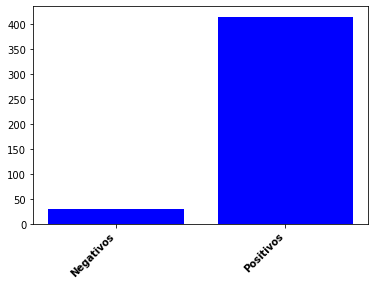

[296, 77, 31]


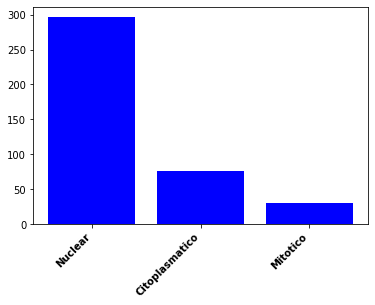

[68, 27, 22, 65, 16, 75, 1, 24, 0, 14, 30, 30, 3, 31]


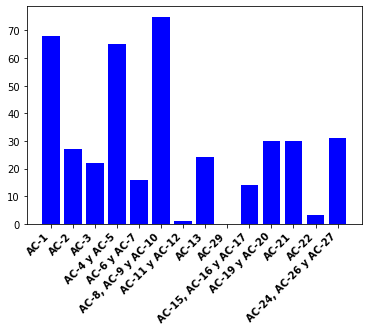

445
388
388


In [7]:
binary_labels = Binary_labeling(labels)
binary_weights = Binary_level_plot(binary_labels)

basic_level_labels = Basic_level_labeling(labels_clean)
basic_level_weights = Basic_level_plot(basic_level_labels)

competent_level_labels = Competent_level_labeling(labels_clean)
competent_level_weights = Competent_level_plot(competent_level_labels)

print(len(binary_labels))
print(len(basic_level_labels))
print(len(competent_level_labels))

# print(binary_labels)
# print(basic_level_labels)
# print(competent_level_labels)

In [8]:
# Creando el dataset

from torch.utils.data import Dataset, DataLoader

Inmuno21_dataset = h5py.File("drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Inmuno21_dataset.h5", 'r')
Inmuno21_dataset_clean = h5py.File("drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Inmuno21_dataset_clean.h5", 'r')

class CustomImageDataset(Dataset):
    def __init__(self, dataset, names, labels, transform=None):
        self.dataset = dataset
        self.names = names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.names[idx]
        image = self.dataset.get(image_name)[:] 
        image = torch.tensor(image)  
        label = torch.tensor(self.labels[idx])    

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Creando Dataloader para la base de datos de Inmuno 21

Batch_size = 20

binary_test_data = CustomImageDataset(Inmuno21_dataset, names, binary_labels)
binary_test_dataloader = DataLoader(binary_test_data, batch_size=Batch_size, shuffle=True, num_workers=2)

basic_test_data = CustomImageDataset(Inmuno21_dataset_clean, names_clean, basic_level_labels)
basic_test_dataloader = DataLoader(basic_test_data, batch_size=Batch_size, shuffle=True, num_workers=2)

competent_test_data = CustomImageDataset(Inmuno21_dataset_clean, names_clean, competent_level_labels)
competent_test_dataloader = DataLoader(competent_test_data, batch_size=Batch_size, shuffle=True, num_workers=2)

# i = 0
# images, labels = next(iter(binary_test_dataloader))
# for image in images: 
#   print(names[i])
#   print(labels[i])
#   plt.imshow(images[i])
#   plt.show()
#   i += 1
  
# i = 0  
# images, labels = next(iter(basic_test_dataloader))
# for image in images: 
#   print(names_clean[i])
#   print(labels_clean[i])
#   plt.imshow(images[i])
#   plt.show()
#   i += 1

# i = 0
# images, labels = next(iter(competent_test_dataloader))
# for image in images: 
#   print(names_clean[i])
#   print(labels_clean[i])
#   plt.imshow(images[i])
#   plt.show()
#   i += 1

# Inmuno21_dataset.close()
# Inmuno21_dataset_clean.close()

In [9]:
# Metricas

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, cohen_kappa_score

def Metrics(Y, Y_hat, device, average):
    average = average
    Y_hat = (Y_hat > 0.5)

    # GPU
    if (device == torch.device('cuda:0')):
      acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
      prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
      recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
      f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0) 
    # CPU
    else:
      acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
      prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
      recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
      f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)

    return(acc, prec, recall, f1) 

In [10]:
def test_model(model, test_dataloader, device, _type):
    
    if (_type == 0):
      model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/(I21_BEST)Binary_model.pt', map_location=device))
      average = 'weighted'
      Y_final = torch.ones((1, 2)).to(device, torch.float32)
      Y_hat_final = torch.ones((1, 2)).to(device, torch.float32)

    elif (_type == 1): 
      model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/Basic_level_model.pt', map_location=device))
      average = 'samples'
      Y_final = torch.ones((1, 3)).to(device, torch.float32)
      Y_hat_final = torch.ones((1, 3)).to(device, torch.float32)

    elif (_type == 2):
      model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/(I21_BEST)Competent_level_model.pt', map_location=device))
      average = 'samples'
      Y_final = torch.ones((1, 14)).to(device, torch.float32)
      Y_hat_final = torch.ones((1, 14)).to(device, torch.float32)

    print("Modelo cargado.\n")
    
    model.to(device)
    
    model.eval()
    test_loss, test_acc, test_prec, test_recall, test_f1 = [], [], [], [], []
    with torch.no_grad():
        for batch in iter(test_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            Y_hat = model(X)

            Y_final = torch.cat((Y_final, Y), dim = 0)              # Concatenamos las salidas correctas de cada lote
            Y_hat_final = torch.cat((Y_hat_final, Y_hat), dim = 0)  # Concatenamos las salidas de cada lote

            # Metricas
            acc, prec, recall, f1 = Metrics(Y, Y_hat, device, average)
            
            test_acc.append(acc)
            test_prec.append(prec) 
            test_recall.append(recall)
            test_f1.append(f1)

    Y_final = Y_final[1:]                                           # Retiramos el primer valor del tensor ya que es una fila de 1
    Y_hat_final = Y_hat_final[1:]                                   # Retiramos el primer valor del tensor ya que es una fila de 1
    Y_hat_final = (Y_hat_final > 0.5)

    kappa = cohen_kappa_score(Y_final.cpu().detach().numpy().flatten() if device == torch.device('cuda:0') else Y_final.detach().numpy().flatten(),
                              Y_hat_final.cpu().detach().numpy().flatten() if device == torch.device('cuda:0') else Y_hat_final.detach().numpy().flatten())
    mcm = multilabel_confusion_matrix(Y_final.cpu().detach().numpy() if device == torch.device('cuda:0') else Y_final.detach().numpy(),
                                      Y_hat_final.cpu().detach().numpy() if device == torch.device('cuda:0') else Y_hat_final.detach().numpy())
    
    #mcm = multilabel_confusion_matrix(Y_final, Y_hat_final, samplewise = True)

    return (np.mean(test_acc), np.mean(test_prec), np.mean(test_recall), np.mean(test_f1), mcm, kappa)

In [11]:
import torch.nn as nn

class Binary_ExtendedNet(nn.Module):
    def __init__(self, pretrained_model):
        super(Binary_ExtendedNet, self).__init__()
        self.pretrained = pretrained_model
        self.new_layer = nn.Sequential( nn.Linear(1000, 1000),
                                        nn.ReLU(),
                                        nn.Dropout(0.4),
                                        nn.Linear(1000, 1000),
                                        nn.ReLU(),
                                        nn.Dropout(0.4),
                                        nn.Linear(1000, 500),
                                        nn.ReLU(),
                                        nn.Dropout(0.4),
                                        nn.Linear(500, 100),
                                        nn.ReLU(),
                                        nn.Dropout(0.4),
                                        nn.Linear(100, 10),
                                        nn.ReLU(),
                                        nn.Dropout(0.4),
                                        nn.Linear(10, 2),
                                        nn.Sigmoid())      
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.pretrained(x)
        x = self.new_layer(x)
        return x

class Basic_ExtendedNet(nn.Module):
    def __init__(self, pretrained_model):
        super(Basic_ExtendedNet, self).__init__()
        self.pretrained = pretrained_model
        self.new_layer = nn.Sequential(  nn.ReLU(),
                                        nn.Dropout(0.1),
                                        nn.Linear(1000, 3),
                                        nn.Sigmoid()
                                         )     
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.pretrained(x)
        x = self.new_layer(x)
        return x

class Competent_ExtendedNet(nn.Module):
    def __init__(self, pretrained_model):
        super(Competent_ExtendedNet, self).__init__()
        self.pretrained = pretrained_model
        self.new_layer = nn.Sequential(nn.ReLU(),
                                         nn.Dropout(0.1),
                                         nn.Linear(1000, 14), 
                                         )     
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.pretrained(x)
        x = self.new_layer(x)
        return x

In [12]:
# Creacion de los modelos

!pip install timm
import torchvision.models as models
import timm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b7(weights='DEFAULT')
binary_model = Binary_ExtendedNet(model)

# model = timm.create_model('inception_resnet_v2', pretrained=True) 
model = models.densenet121(weights='DEFAULT')
basic_model = Basic_ExtendedNet(model)

model = timm.create_model('inception_resnet_v2', pretrained=True) 
competent_model = Competent_ExtendedNet(model)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 5.2 MB/s 
     |████████████████████████████████| 163 kB 81.2 MB/s 


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/inception_resnet_v2-940b1cd6.pth" to /root/.cache/torch/hub/checkpoints/inception_resnet_v2-940b1cd6.pth


In [13]:
# Prueba del modelo para clasificacion Binaria

start_time = time.time()
test_acc, test_pre, test_recall, test_F1, test_mcm, test_kappa = test_model(
    binary_model, 
    binary_test_dataloader, 
    device,
    0)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test para 2 clases:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_pre, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2))
print("Coeficiente Kappa:", test_kappa)
print("Matrices de confusion: \n: ", test_mcm)

Modelo cargado.

Tiempo de test: 0.346 

Metricas del test para 2 clases:
 Exactitud:  0.94  Precision:  0.94  Recall:  0.94  F1:  0.94
Coeficiente Kappa: 0.8831460674157303
Matrices de confusion: 
:  [[[405  10]
  [ 16  14]]

 [[ 14  16]
  [ 10 405]]]


In [14]:
# Prueba del modelo para clasificacion Basica

start_time = time.time()
test_acc, test_pre, test_recall, test_F1, test_mcm, test_kappa = test_model(
    basic_model, 
    basic_test_dataloader, 
    device,
    1)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test para 3 clases:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_pre, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2))
print("Coeficiente Kappa:", test_kappa)
print("Matrices de confusion: \n: ", test_mcm)

Modelo cargado.

Tiempo de test: 0.089 

Metricas del test para 3 clases:
 Exactitud:  0.76  Precision:  0.85  Recall:  0.92  F1:  0.87
Coeficiente Kappa: 0.7757664565516719
Matrices de confusion: 
:  [[[ 49  43]
  [  7 289]]

 [[270  41]
  [ 11  66]]

 [[353   4]
  [ 16  15]]]


In [15]:
# Prueba del modelo para clasificacion Competente

start_time = time.time()
test_acc, test_pre, test_recall, test_F1, test_mcm, test_kappa = test_model(
    competent_model, 
    competent_test_dataloader, 
    device,
    2)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test para 13 clases:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_pre, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2))
print("Coeficiente Kappa:", test_kappa)
print("Matrices de confusion: \n", test_mcm)

Modelo cargado.

Tiempo de test: 0.122 

Metricas del test para 13 clases:
 Exactitud:  0.25  Precision:  0.39  Recall:  0.53  F1:  0.43
Coeficiente Kappa: 0.3741721476854333
Matrices de confusion: 
 [[[290  30]
  [ 37  31]]

 [[335  26]
  [ 21   6]]

 [[365   1]
  [ 10  12]]

 [[198 125]
  [ 14  51]]

 [[348  24]
  [  7   9]]

 [[268  45]
  [ 11  64]]

 [[373  14]
  [  1   0]]

 [[362   2]
  [ 24   0]]

 [[381   7]
  [  0   0]]

 [[345  29]
  [  5   9]]

 [[345  13]
  [ 30   0]]

 [[337  21]
  [ 17  13]]

 [[374  11]
  [  2   1]]

 [[332  25]
  [ 14  17]]]
